### Solar IDS classification

This notebook illustrates the performance of classifying the houses between solar and no solar usign batch data.
The idea is to possibly feed this information to improve the algorithm accuracy. 

In [1]:
# The script aims at assessing the separation of Solar from non Solar IDS
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from os import path
from importlib import reload
import datetime as dt
import numpy as np
import pandas as pd
from time import time
import pickle as pk
import matplotlib.pyplot as plt
import Custom_Functions.error_functions as ef
from csss.utilities import Setup_load as SetUp_load
from IPython import get_ipython
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

In [2]:
# Loading the main data
Setup_load = deepcopy(SetUp_load())
Setup_load.QueryOrLoad()
load_data, load_data_2, weather, grouped_data, ids, solar_ids, homeids  = Setup_load.load_setup()
load_data = deepcopy(load_data_2) # I need the data in this format for this script
netload = load_data['netload']
ids = list(netload.columns)

reading 61047030 values from csv took 17.70 seconds
There are 167 homes with complete data
105 homes solar
62 homes with no solar


In this section I remove those sites that for some reasons have 0 generation for 3 days in a row. In fact it seems odd and there could have been maintenance issues or breakdowns. The impact of these variables is not of interest here. 

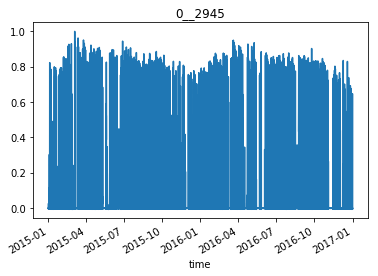

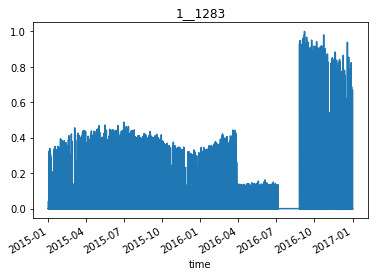

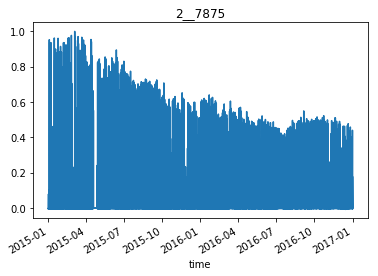

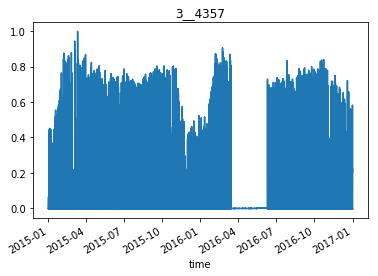

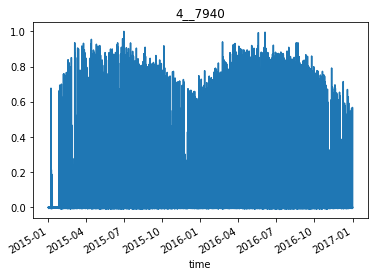

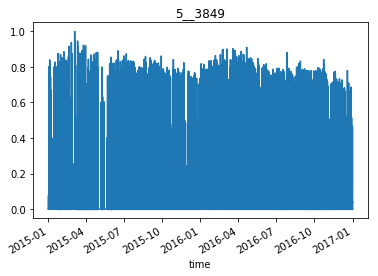

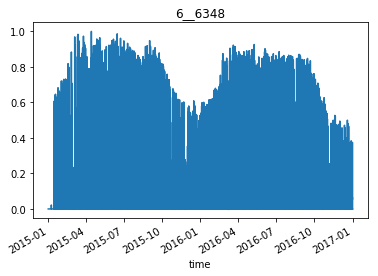

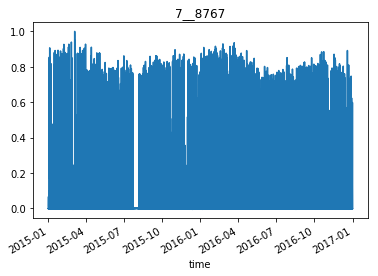

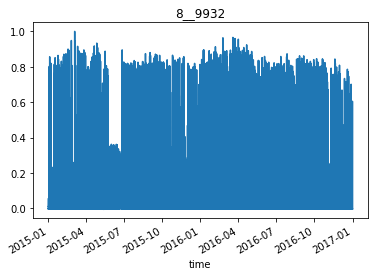

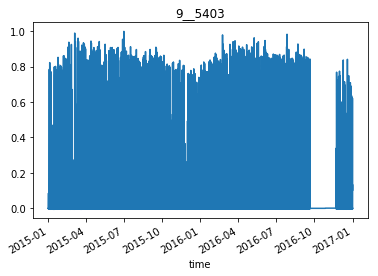

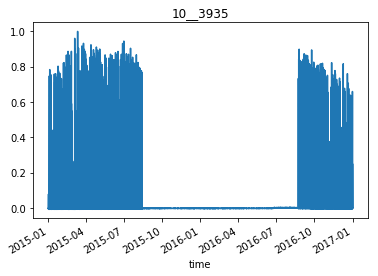

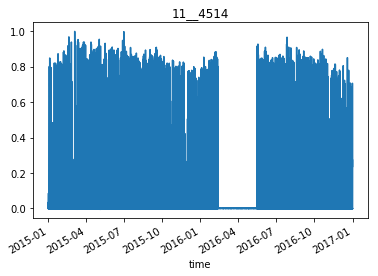

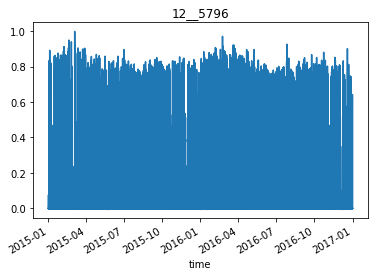

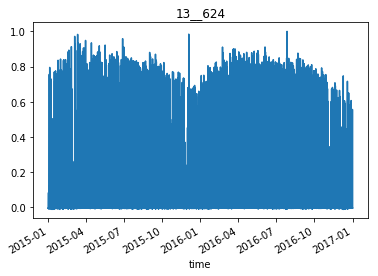

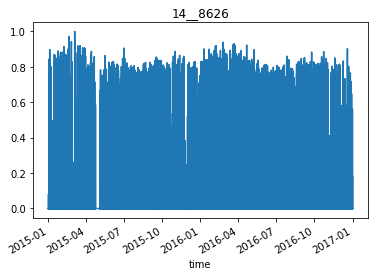

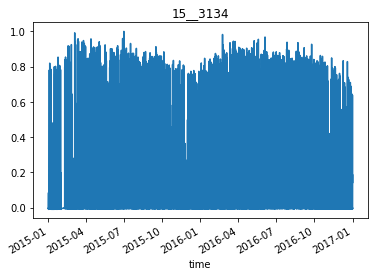

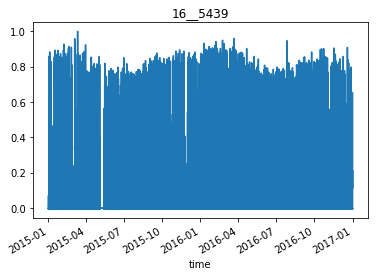

In [4]:
N_obs_day = 96 # number of observations in one day.
N_obs = 3*N_obs_day
remove = []
for i in solar_ids['solar']:
    df = grouped_data.get_group(i)
    roll_mean = df.gen.rolling(N_obs).mean()
    if np.nansum(roll_mean < 0.001) > 0:
        remove.append(i)
len(remove)

remove = set(remove)

# plotting - Looking at the results it might be a bit aggressive, but some of them definitely needed to be removed. 
plt.close('all')
for i,j in enumerate(remove):
   df = grouped_data.get_group(j)
   plt.figure()
   (df.gen/np.max(np.abs(df.gen))).plot()
   plt.title(str(i)+'__'+str(j))
   plt.show()
ids = list(set(ids)-set(remove))

# Drop the removed data from netload
netload = netload.drop(remove,axis = 1)
ids = netload.columns

### K-means Clustering based on average load shape
The idea is to cluster the solar ids according to their average load shape. 

In [45]:
Load_shape = netload.groupby([netload.index.hour,netload.index.minute]).mean()
Load_shape_norm = deepcopy(Load_shape/np.max(np.abs(Load_shape.values), axis = 0))

X = Load_shape_norm.values
KMeans_ = deepcopy(KMeans(n_clusters=2, init='random', n_init=10))
X = X.T # because Kmeans wants X = (n_samples, n_features)

# Fitting
KMeans_.fit(X)
Solar_split = KMeans_.predict(X)

if KMeans_.cluster_centers_.mean(axis = 1)[1] > KMeans_.cluster_centers_.mean(axis = 1)[0]:
    Solar_split = np.abs(1-Solar_split) # Because K_means does not know which class should have 1 or zero. Ideally the centroid of the netload of no solar houses will have a higher average than solar ones. 

true_split = np.asarray([i in solar_ids['solar'] for i in netload.columns]).astype('float')
accuracy = 1-sum(np.abs(Solar_split - true_split))/len(Solar_split)
print('The accuracy is ',accuracy)


The accuracy is  0.94


In [49]:
misclass  = true_split - Solar_split # 0: correctly classified. 1:False Negative -1: False Positive
FN = deepcopy(misclass)
FN[FN<1] = 0 # They are solar houses, but the algorithm does not detect the solar.
FP = deepcopy(misclass)
FP[FP>-1] = 0 # They have no solar, but the algorithm thinks they have solar. 
print('There are {} misclassified. FP = {} , FN = {}.'.format(sum(np.abs(misclass)),sum(FP),sum(FN)))


There are 9.0 misclassified. FP = 0.0 , FN = 9.0.


Identify who are the FN, plot their timeseries and Capacity/max(Netload) ratio, together with the average hourly netload profile.

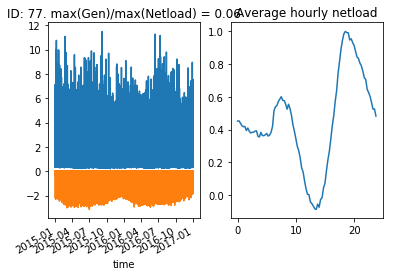

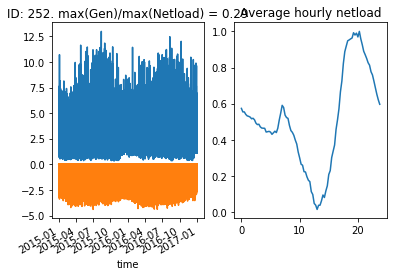

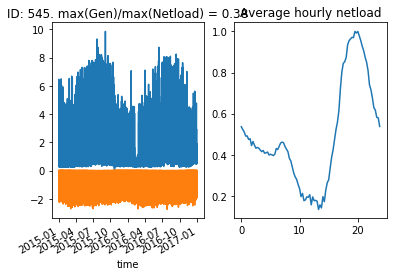

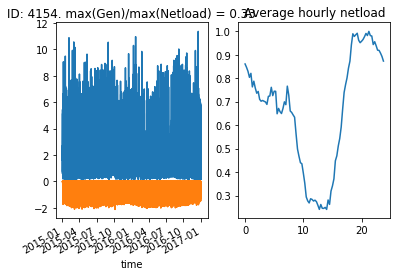

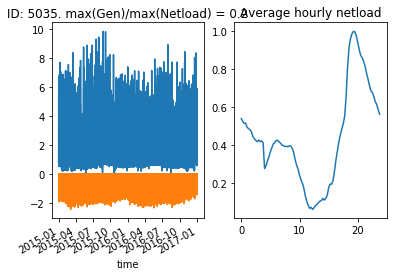

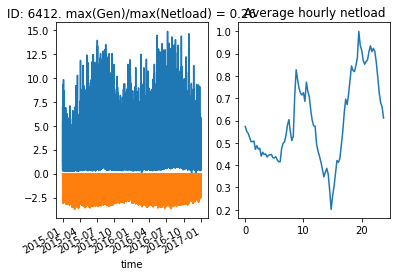

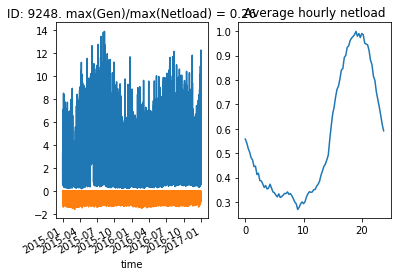

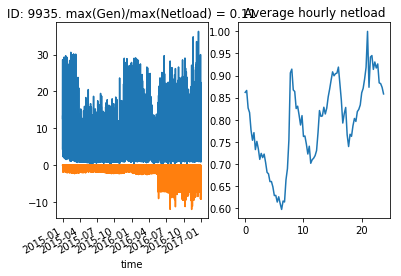

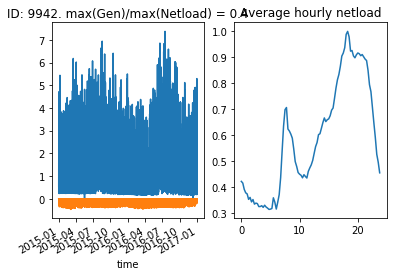

[0.06366375219967016, 0.2860770439294109, 0.3840503855682334, 0.3272415853415654, 0.1969202516410021, 0.25560817285833204, 0.26100063094431336, 0.11295749535075443, 0.39821744274149595]


In [115]:

misclass_ids = deepcopy(np.asarray(netload.columns)[FN == 1])
p_p_ratio = []
for j,i in enumerate(misclass_ids):
    p_p_ratio.append(np.abs(np.max(np.abs(dg.gen)))/dg.netload.max())
    plt.figure()
    dg = grouped_data.get_group(i)
    plt.subplot(1,2,1)
    dg.use.plot()
    plt.plot(-dg.gen)
    plt.title('ID: ' + str(i) + '. max(Gen)/max(Netload) = ' + str(round(p_p_ratio[j],2)) )
    plt.subplot(1,2,2)
    plt.plot(np.linspace(0,24,97)[0:-1],Load_shape_norm[i].values)
    plt.title('Average hourly netload')
    plt.show()
print(p_p_ratio)

In [114]:
np.vectorize(round)(p_p_ratio,2)

array([0.06, 0.29, 0.38, 0.33, 0.2 , 0.26, 0.26, 0.11, 0.4 ])

Conclusion: The method distinguished solar from non solar houses with 94% accuracy. All the misclassified items are FN, meaning that the algorithm does not detect solar in this case. Finally apart for one ID which have a Capacity/Netload ratio of 6%, all the other ones shows a significant ratio, on average around 30%. This was unexpected, therefore more investigation would be required to understand why these load shapes are misclassified.